In [1]:
%matplotlib inline
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys
import pandas as pd
sys.path.append('../../param_search')
import param_search as ps

## Setup experiment

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [3]:
# define a job template and name format
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:v100-32:1
#SBATCH --mem=63000M
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project
nvidia-smi

python ../../../train.py \\
    --data_name emory \\
    --data_root /ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/ \\
    --mask_roi {mask_roi} \\
    --mesh_version {mesh_version} \\
    --test_case {test_case} \\
    --test_phase {test_phase} \\
    --model_arch {model_arch} \\
    --input_anat {input_anat} \\
    --input_coords {input_coords} \\
    --conv_channels {conv_channels} \\
    --output_func {output_func} \\
    --trainer_task {trainer_task} \\
    --rho_value {rho_value} \\
    --interp_size {interp_size} \\
    --learning_rate {lr:.0e} \\
    --num_epochs {num_epochs} \\
    --test_every {test_every} \\
    --save_every {save_every} \\
    --save_prefix {job_name}

echo Done
'''

In [4]:
param_space = ps.ParamSpace(
    mask_roi='lung_regions2',
    mesh_version=11,
    test_case=[None], #['Case1Pack', 'Case2Pack', 'Case3Pack', 'Case4Pack', 'Case5Pack', 'Case6Pack', 'Case7Pack', 'Case8Deploy', 'Case9Pack'],
    test_phase=[0], # 10, 20, 30, 40, 50, 60, 70, 80, 90],
    rho_value=[0, 1000, 'anat'],
    conv_channels=[32],
    interp_size=[5],
    output_func=['relu', 'exp', 'softplus'],
)
name_format = 'train__emory__{test_case}__{test_phase}__{rho_value}__{output_func}'

## fitting

param_space = ps.ParamSpace(
    mask_roi='lung_regions2',
    mesh_version=11,
    test_case=['Case10Pack'], #['Case1Pack', 'Case2Pack', 'Case3Pack', 'Case4Pack', 'Case5Pack', 'Case6Pack', 'Case7Pack', 'Case8Deploy', 'Case9Pack'],
    test_phase=[0], # 10, 20, 30, 40, 50, 60, 70, 80, 90],
    input_anat=[True, False],
    input_coords=[True],
    model_arch=['unet3d'],
    conv_channels=[32],
    output_func=['softplus'],
    trainer_task=['fit'],
    rho_value=[0, 1000, 'anat'],
    interp_size=[5],
    lr=[1e-5],
    num_epochs=1000,
    test_every=100,
    save_every=100,
)
name_format = 'fit__emory__{input_anat:d}{input_coords:d}__{output_func}__{rho_value}__{test_case}__{test_phase}'


for p in param_space:
    print(name_format.format(**p))

print(len(param_space))

fit__emory__11__softplus__0__Case10Pack__0
fit__emory__11__softplus__1000__Case10Pack__0
fit__emory__11__softplus__anat__Case10Pack__0
fit__emory__01__softplus__0__Case10Pack__0
fit__emory__01__softplus__1000__Case10Pack__0
fit__emory__01__softplus__anat__Case10Pack__0
6


## Submit jobs

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [5]:
expt_name = [
    '2024-11-22__phantom__250',
    '2024-11-22__phantom__250__resub',
    '2024-11-30__emory__phase',
    '2024-12-02__emory__interp_size',
    '2024-12-03__emory__gpu_shared',
    '2024-12-07__emory__interface',
    '2024-12-08__emory__lung_regions2',
    '2024-12-08__emory__clamp',
    '2024-12-12__emory__fit'
][-1]
expt_name

'2024-12-12__emory__fit'

In [6]:
do_submit = False
if do_submit:
    jobs = ps.submit(template, name_format, param_space, work_dir=expt_name)
    jobs.to_csv(f'{expt_name}.jobs')

## Monitor jobs

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [7]:
jobs = pd.read_csv(f'{expt_name}.jobs', index_col=0)
status = ps.status(jobs, parse_stderr=True)
status

,index,mask_roi,mesh_version,test_case,test_phase,input_anat,input_coords,model_arch,conv_channels,output_func,...,save_every,job_name,partition,job_state,node_id,runtime,work_dir,array_idx,stdout,stderr
job_id,,,,,,,,,,,,,,,,,,,,,
27636742,0,lung_regions2,11,Case10Pack,0,True,True,unet3d,32,softplus,...,100,fit__emory__11__softplus__0__Case10Pack__0,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,v008.ib.bridges2.psc.edu\n/ocean/projects/asc1...,
27636743,1,lung_regions2,11,Case10Pack,0,True,True,unet3d,32,softplus,...,100,fit__emory__11__softplus__1000__Case10Pack__0,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,v002.ib.bridges2.psc.edu\n/ocean/projects/asc1...,
27636744,2,lung_regions2,11,Case10Pack,0,True,True,unet3d,32,softplus,...,100,fit__emory__11__softplus__anat__Case10Pack__0,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,v002.ib.bridges2.psc.edu\n/ocean/projects/asc1...,
27636745,3,lung_regions2,11,Case10Pack,0,False,True,unet3d,32,softplus,...,100,fit__emory__01__softplus__0__Case10Pack__0,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,v010.ib.bridges2.psc.edu\n/ocean/projects/asc1...,
27636746,4,lung_regions2,11,Case10Pack,0,False,True,unet3d,32,softplus,...,100,fit__emory__01__softplus__1000__Case10Pack__0,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,v010.ib.bridges2.psc.edu\n/ocean/projects/asc1...,
27636747,5,lung_regions2,11,Case10Pack,0,False,True,unet3d,32,softplus,...,100,fit__emory__01__softplus__anat__Case10Pack__0,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,v010.ib.bridges2.psc.edu\n/ocean/projects/asc1...,


In [8]:
status['job_state'] = status['job_state'].fillna('DONE')
status['stderr'] = status['stderr'].fillna('N/A')
status.groupby(['job_state', 'stderr'])[['job_name']].count()

,,job_name
job_state,stderr,
DONE,,6


In [9]:
status.iloc[0]

index                                                            0
mask_roi                                             lung_regions2
mesh_version                                                    11
test_case                                               Case10Pack
test_phase                                                       0
input_anat                                                    True
input_coords                                                  True
model_arch                                                  unet3d
conv_channels                                                   32
output_func                                               softplus
trainer_task                                                   fit
rho_value                                                        0
interp_size                                                      5
lr                                                         0.00001
num_epochs                                                    

## Analyze results

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [10]:
m = ps.metrics(jobs, sep=',')
m

,mask_roi,mesh_version,test_case,test_phase,input_anat,input_coords,model_arch,conv_channels,output_func,trainer_task,...,true_dis0_corr,true_dis1_corr,true_dis2_corr,event,time,gpu_mem_total,gpu_mem_reserved,gpu_mem_allocated,mem_total,mem_used
0,lung_regions2,11,Case10Pack,0,True,True,unet3d,32,softplus,fit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lung_regions2,11,Case10Pack,0,True,True,unet3d,32,softplus,fit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,lung_regions2,11,Case10Pack,0,True,True,unet3d,32,softplus,fit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,lung_regions2,11,Case10Pack,0,True,True,unet3d,32,softplus,fit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,lung_regions2,11,Case10Pack,0,True,True,unet3d,32,softplus,fit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115,lung_regions2,11,Case10Pack,0,False,True,unet3d,32,softplus,fit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6116,lung_regions2,11,Case10Pack,0,False,True,unet3d,32,softplus,fit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6117,lung_regions2,11,Case10Pack,0,False,True,unet3d,32,softplus,fit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6118,lung_regions2,11,Case10Pack,0,False,True,unet3d,32,softplus,fit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
m.groupby(['job_name'])[['epoch']].max()

,epoch
job_name,
fit__emory__01__softplus__0__Case10Pack__0,1000
fit__emory__01__softplus__1000__Case10Pack__0,1000
fit__emory__01__softplus__anat__Case10Pack__0,1000
fit__emory__11__softplus__0__Case10Pack__0,1000
fit__emory__11__softplus__1000__Case10Pack__0,1000
fit__emory__11__softplus__anat__Case10Pack__0,1000


In [12]:
m.groupby(['job_name'])[['batch']].max()

,batch
job_name,
fit__emory__01__softplus__0__Case10Pack__0,1
fit__emory__01__softplus__1000__Case10Pack__0,1
fit__emory__01__softplus__anat__Case10Pack__0,1
fit__emory__11__softplus__0__Case10Pack__0,1
fit__emory__11__softplus__1000__Case10Pack__0,1
fit__emory__11__softplus__anat__Case10Pack__0,1


In [13]:
m.columns

Index(['mask_roi', 'mesh_version', 'test_case', 'test_phase', 'input_anat',
       'input_coords', 'model_arch', 'conv_channels', 'output_func',
       'trainer_task', 'rho_value', 'interp_size', 'lr', 'num_epochs',
       'test_every', 'save_every', 'job_name', 'job_id', 'partition',
       'job_state', 'node_id', 'runtime', 'work_dir', 'array_idx', 'epoch',
       'batch', 'example', 'phase', 'rep', 'u_error', 'u_pred_norm',
       'u_true_norm', 'e_error', 'e_pred_norm', 'e_true_norm', 'CTE',
       'e_true_corr', 'e_anat_corr', 'true_anat_corr', 'e_950_corr',
       'e_900_corr', 'e_850_corr', 'true_950_corr', 'true_900_corr',
       'true_850_corr', 'e_dis0_corr', 'e_dis1_corr', 'e_dis2_corr',
       'true_dis0_corr', 'true_dis1_corr', 'true_dis2_corr', 'event', 'time',
       'gpu_mem_total', 'gpu_mem_reserved', 'gpu_mem_allocated', 'mem_total',
       'mem_used'],
      dtype='object')

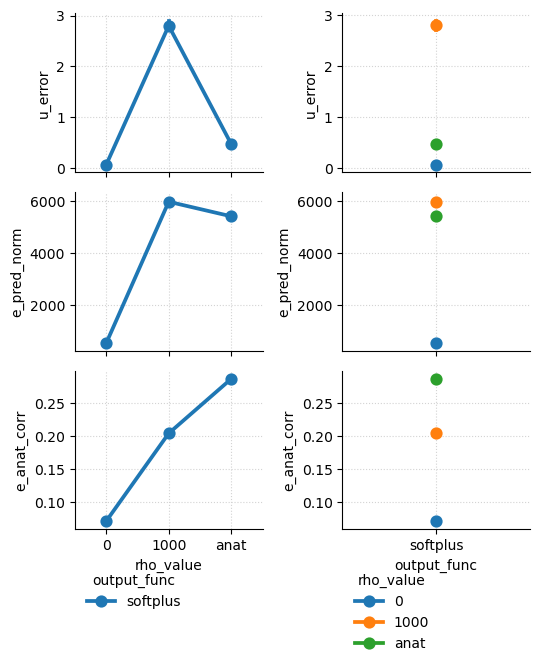

In [14]:
%autoreload

fig = ps.plot(
    m[(m.phase == 'train') & (m.epoch > 100)],
    x=['rho_value', 'output_func'],
    y=['u_error', 'e_pred_norm', 'e_anat_corr'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75
)

In [15]:
fig = ps.plot(
    m[(m.phase == 'test') & (m.epoch > 100) & (m.rep == 'dofs')],
    x=['rho_value', 'output_func'],
    y=['u_error', 'e_pred_norm', 'e_anat_corr'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75
)

AssertionError: empty data frame

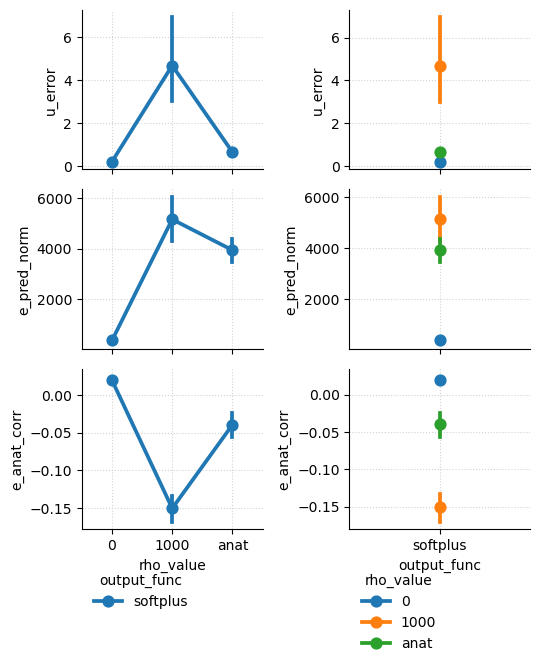

In [16]:
fig = ps.plot(
    m[(m.phase == 'test') & (m.epoch > 100) & (m.rep == 'image')],
    x=['rho_value', 'output_func'],
    y=['u_error', 'e_pred_norm', 'e_anat_corr'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75
)

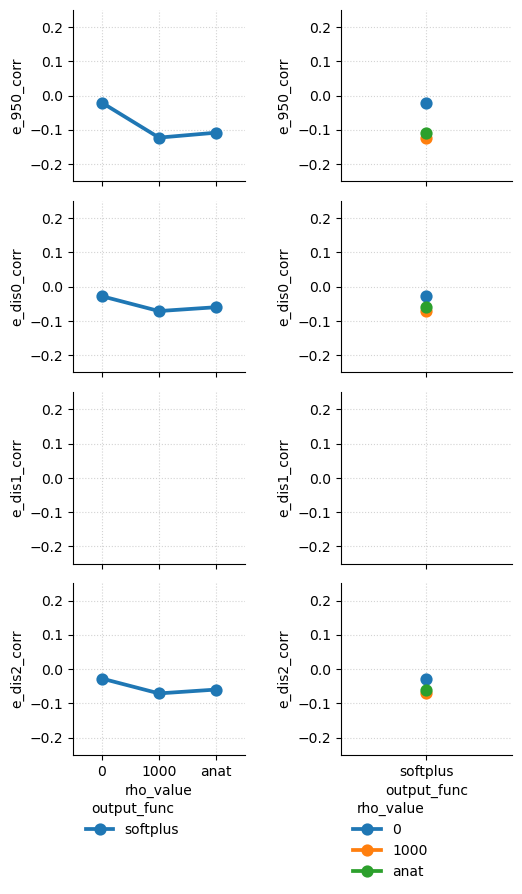

In [17]:
fig = ps.plot(
    m[(m.phase == 'train') & (m.epoch > 100)],
    x=['rho_value', 'output_func'],
    y=['e_950_corr', 'e_dis0_corr', 'e_dis1_corr', 'e_dis2_corr'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75
)
for ax in fig.axes:
    ax.set_ylim(-0.25, 0.25)

In [18]:
fig = ps.plot(
    m[(m.phase == 'test') & (m.epoch > 100) & (m.rep == 'dofs')],
    x=['rho_value', 'output_func'],
    y=['e_950_corr', 'e_dis0_corr', 'e_dis1_corr', 'e_dis2_corr'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75
)
for ax in fig.axes:
    ax.set_ylim(-0.25, 0.25)

AssertionError: empty data frame

## Image grids

In [19]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

In [20]:
param_space = ps.ParamSpace(
    mask_roi='lung_regions2',
    mesh_verson=[11],
    model_arch=['unet3d'],
    conv_channels=[32],
    rho_value=[1000],
    lr=[1e-5],
) * (
    ps.ParamSpace(
        trainer_task=['train'],
        input_anat=[True],
        input_coords=[False],
        output_func=['softplus'],
        num_epochs=200,
    ) + ps.ParamSpace(
        trainer_task=['fit'],
        input_anat=[True, False],
        input_coords=[True],
        output_func=['softplus'],
        num_epochs=1000
    )
)
name_formats = [
    'train__emory__{test_case}__{test_phase}__{rho_value}__{output_func}',
    'fit__emory__{input_anat:d}{input_coords:d}__{output_func}__{rho_value}__{test_case}__{test_phase}',
    'fit__emory__{input_anat:d}{input_coords:d}__{output_func}__{rho_value}__{test_case}__{test_phase}',
]
expt_names = [
    '2024-12-08__emory__clamp',
    '2024-12-12__emory__fit',
    '2024-12-12__emory__fit',
]
len(param_space)

3

In [21]:
%autoreload
import numpy as np
import torch

n_models = 3
n_cases = 9

masks = []
d_masks = []
a_images = []
e_images = []

masks = [[] for i in range(n_models)]
d_masks = [[] for i in range(n_models)]
a_images = [[] for i in range(n_models)]
e_preds = [[] for i in range(n_models)]

for i in range(n_models):
    for j in range(n_cases):
        case_name = ('Case8Deploy' if j == 7 else f'Case{j+1}Pack')
        job_params = param_space[i]
        if job_params['trainer_task'] == 'train':
            job_params['test_case'] = None
        else:
            job_params['test_case'] = case_name
        job_params['test_phase'] = 0
        job_name = name_formats[i].format(**job_params)
        expt_name = expt_names[i]
        print(job_name)

        data_root = f'/ocean/projects/asc170022p/shared/Data/4DLungCT/Emory/'
        fixed_phase = 0
        case = project.imaging.Emory4DCTCase(data_root, case_name, project.imaging.ALL_PHASES)
    
        anat_file = case.nifti_file(fixed_phase)
        mask_file = case.totalseg_mask_file(fixed_phase, roi='lung_regions2')
        d_mask_file = case.medpseg_mask_file(fixed_phase, roi='findings')
        
        mask_nifti = project.data.load_nii_file(mask_file)
        mask = mask_nifti.get_fdata()
        resolution = mask_nifti.header.get_zooms()
        a_image = project.data.load_nii_file(anat_file).get_fdata()
        d_mask = project.data.load_nii_file(d_mask_file).get_fdata()
        print(mask.shape, a_image.shape, d_mask.shape)
    
        shape = a_image.shape
        if job_params['model_arch'] == 'unet3d':
            model = project.model.UNet3D(
                in_channels=1*job_params['input_anat'] + 3*job_params['input_coords'],
                out_channels=1,
                num_levels=3,
                num_conv_layers=2,
                conv_channels=job_params['conv_channels'],
                conv_kernel_size=3,
                output_func=job_params['output_func']
            ).cuda()
            
        elif job_params['model_arch'] == 'param_map':
            model = project.model.ParameterMap(
                shape=(1, shape[0]//2, shape[1]//2, shape[2]//2),
                upsample_mode='nearest',
                conv_kernel_size=3,
                output_func=job_params['output_func']
            ).cuda()
        
        epoch = job_params['num_epochs']
        model_path = f'{expt_name}/{job_name}/state/model_{epoch}.pt'
        model.load_state_dict(torch.load(model_path))
        
        binary_mask = torch.as_tensor(mask > 0, device='cuda')
        c_t = project.training.get_input_coords(binary_mask, resolution)
        a_t = torch.as_tensor(a_image, dtype=torch.float32, device='cuda').unsqueeze(0)
        if job_params['input_anat'] and job_params['input_coords']:
            input_t = torch.cat([a_t, c_t], dim=0)
        elif job_params['input_coords']:
            input_t = c_t
        elif job_params['input_anat']:
            input_t = a_t

        e_t = (model.forward(input_t[None,...])[0,0]*1000).clamp(min=1, max=1e12)
        e_pred = e_t.detach().cpu().numpy() * (mask > 0)
        
        masks[i].append(mask)
        a_images[i].append(a_image)
        e_preds[i].append(e_pred)
        d_masks[i].append(d_mask)
        
        del model


train__emory__None__0__1000__softplus
(256, 256, 94) (256, 256, 94) (256, 256, 94)


/var/tmp/ipykernel_103574/1194211807.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/ocean/projects/asc170022p/mtragoza/m

train__emory__None__0__1000__softplus
(256, 256, 94) (256, 256, 94) (256, 256, 94)
train__emory__None__0__1000__softplus
(256, 256, 94) (256, 256, 94) (256, 256, 94)
train__emory__None__0__1000__softplus
(256, 256, 94) (256, 256, 94) (256, 256, 94)
train__emory__None__0__1000__softplus
(256, 256, 94) (256, 256, 94) (256, 256, 94)
train__emory__None__0__1000__softplus
(256, 256, 94) (256, 256, 94) (256, 256, 94)
train__emory__None__0__1000__softplus
(256, 256, 94) (256, 256, 94) (256, 256, 94)
train__emory__None__0__1000__softplus
(256, 256, 94) (256, 256, 94) (256, 256, 94)
train__emory__None__0__1000__softplus
(256, 256, 94) (256, 256, 94) (256, 256, 94)
fit__emory__11__softplus__1000__Case1Pack__0
(256, 256, 94) (256, 256, 94) (256, 256, 94)
fit__emory__11__softplus__1000__Case2Pack__0
(256, 256, 94) (256, 256, 94) (256, 256, 94)
fit__emory__11__softplus__1000__Case3Pack__0
(256, 256, 94) (256, 256, 94) (256, 256, 94)
fit__emory__11__softplus__1000__Case4Pack__0
(256, 256, 94) (256, 

In [22]:
x_shape, y_shape, z_shape = (256, 256, 94)
x_res, y_res, z_res = (0.97, 0.97, 2.5)

x_extent = (x_shape - 1) * x_res
y_extent = (y_shape - 1) * y_res
z_extent = (z_shape - 1) * z_res

y_slice = y_shape//2

ax_height = 1.5
ax_width = ax_height * x_extent/z_extent
print((ax_height, ax_width))

e_cmap = project.visual.mre_color_map()

(1.5, 1.5958064516129031)


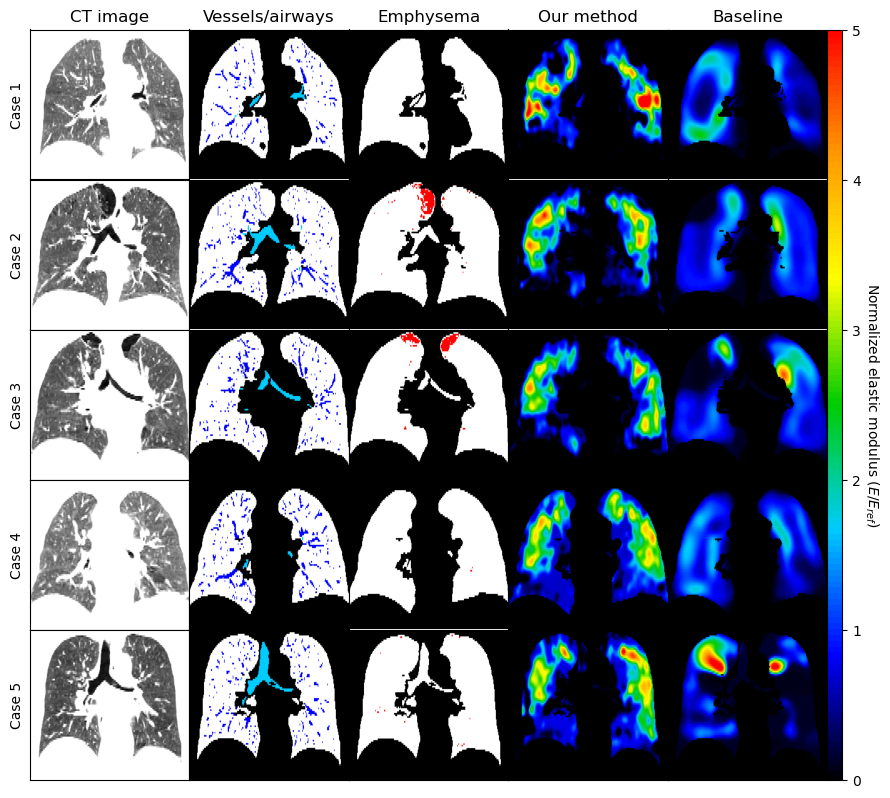

In [32]:
%autoreload
import matplotlib.pyplot as plt

def get_y_slice(mask):
    density = mask.sum(axis=(0,2)) / mask.sum()
    return np.abs(density.cumsum() - 0.5).argmin()

def get_vmax(e_pred, mask):
    e_pred = np.where(mask > 0, e_pred, np.nan)
    return np.nanpercentile(e_pred, 50) * 6
    

model_names = [
    'Our method',
    'Baseline 1',
    'Baseline'
]
model_inds = [0, 2]

columns = ['anat', 'mask', 'd_mask'] + model_inds
cases = range(5)

n_rows = len(cases)
n_cols = len(columns)

fig, axes, cbar_ax = project.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, cbar_width=0.15, space=0, pad=1)

for row_idx, case_idx in enumerate(cases):
    
    mask = masks[0][case_idx]
    d_mask = d_masks[0][case_idx]
    a_image = a_images[0][case_idx]
    d_mask = (a_image < -910) * (mask != 6)

    y_slice = get_y_slice(mask**2)
    
    for col_idx, column in enumerate(columns):
        ax = axes[row_idx,col_idx]

        if col_idx == 0:
            ax.set_ylabel(f'Case {case_idx+1}')
            
        if column == 'anat':
            if row_idx == 0:
                ax.set_title('CT image')
            project.visual.imshow(
                ax, (a_image)[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                **project.visual.get_color_map('CT')
            )
        
        elif column == 'mask':
            if row_idx == 0:
                ax.set_title('Vessels/airways')
            project.visual.imshow(
                ax, mask[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                **project.visual.get_color_map('regions')
            )
            
        elif column == 'd_mask':
            if row_idx == 0:
                ax.set_title('Emphysema')
            im = project.visual.imshow(
                ax, ((1 + d_mask)*(mask > 0))[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                **project.visual.get_color_map('regions')
            )
    
        else: # elasticity map
            model_idx = column
            model_name = model_names[model_idx]
            if row_idx == 0:
                ax.set_title(model_name)
            e_pred = e_preds[model_idx][row_idx] / 5000
            vmax = get_vmax(e_pred, mask)
            im = project.visual.imshow(
                ax, (e_pred)[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                cmap=e_cmap, vmax=vmax, vmin=-vmax
            )

        ax.set_xticks([])
        ax.set_yticks([])

plt.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylim(0, 5)
#cbar_ax.set_yticklabels(['0 kPa', '1', '2', '3', '4', '5', '6 kPa'])
cbar_ax.set_ylabel('Normalized elastic modulus ($E/E_{ref}$)', rotation=270, labelpad=14)

for ext in ['png', 'pdf']:
    fig.savefig(f'emory_lung_images.{ext}', bbox_inches='tight', dpi=400)